In [1]:
import tensorflow as tf
import keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instance Normalization Reference:
https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py

In [2]:
# As mentioned in the paper we are using instance normalization.
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.

    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.

    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.

    # Output shape
        Same shape as input.

    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



Cycle GAN Model

In [10]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from matplotlib import pyplot

######## Discriminator Architecture ########## 
'''we use 70 × 70 PatchGANs which aim to classify whether 70 ×70overlapping image patches are real or fake
 The discriminator architecture is: C64-C128-C256-C512
 After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  
 The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.'''

def discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
 
  # Ck denotes 4 ×4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2.
	# C64
	# We do not use InstanceNorm for the first C64 layer.
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d) 
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d) 
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
 
	# compiling the model
  #The model is trained with a batch size of one and Adam optimizer with 0.0002 learning rate and 0.5 beta.

	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

############ Generator Architecture ###################
''' Generator contains a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.'''

def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first 3 x 3 convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second 3 x 3 convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# Generator Model
''' The network with 9 residual blocks consists of:
c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1. 
dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
Reflection padding was used to reduce artifacts. Rk denotes a residual block that contains two 3 × 3 convolutional layers.
uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2
'''

def generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g) 
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g) 
	# R256 
	for _ in range(n_resnet):
		g = resnet_block(256, g)	
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
 
	# define model
	model = Model(in_image, out_image)
	return model

'''Generator is trained via combined model to mininmize 4 differnet losses - adversarial, cycle loss - forward, cycle loss - backward and identity loss
 define a composite model for updating generators by adversarial and cycle loss
 We define a composite model that will be used to train each generator separately. '''

def composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Making the generator of interest trainable as we will be updating these weights by keeping other models constant.
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False
    
	# adversarial loss (L2 loss - MSE)
	'''To stabilize our model training procedure, we apply a technique from recent works,
	we replace the negative log likelihood objective by a least-squares loss'''
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss (L1 loss - MAE)
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward (L1 loss - MAE)
	output_f = g_model_2(gen1_out)
	# cycle loss - backward (L1 loss - MAE)
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)   
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
  # Adam optimizer with 0.0002 learning rate 
	opt = Adam(lr=0.0002, beta_1=0.5)
 
	# The weight for the cycle consistency loss (λ) is set to 10. And weight for identity mapping loss is (0.5λ) = 5.
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	data = load(filename)
 
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# Generate Real Samples
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels, y = (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# Generate Fake samples
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels, y = (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# Saving the generator models to file
def save_models(step, g_model_XtoY, g_model_YtoX):
	# save the first generator(G) model
	filename1 = 'g_model_XtoY_%06d.h5' % (step+1)
	g_model_XtoY.save(filename1)
 
	# save the second generator(F) model
	filename2 = 'g_model_YtoX_%06d.h5' % (step+1)
	g_model_YtoX.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0

	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()


'''Another way to stabilize the training procedure,to reduce model oscillation.
update discriminators using a history of generated images rather than the ones produced by the latest generators. 
We keep an image buffer that stores the 50 previously created images.
'''

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan model
def train(d_model_X, d_model_Y, g_model_XtoY, g_model_YtoX, c_model_XtoY, c_model_YtoX, dataset, epochs=1):
	# batch size fixed to 1
	n_epochs, n_batch, = epochs, 1   
	# determine the output square shape of the discriminator
	n_patch = d_model_X.output_shape[1]
	# unpack dataset
	trainX, trainY = dataset
	# prepare image pool for fake images
	poolX, poolY = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainX) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (X and Y)
		X_real_domain_X, y_real_domain_X = generate_real_samples(trainX, n_batch, n_patch)
		X_real_domain_Y, y_real_domain_Y = generate_real_samples(trainY, n_batch, n_patch)
	
		# generate a batch of fake samples using both Y to X and X to Y generators.
		X_fake_domain_X, y_fake_domain_X = generate_fake_samples(g_model_YtoX, X_real_domain_Y, n_patch)
		X_fake_domain_Y, y_fake_domain_Y = generate_fake_samples(g_model_XtoY, X_real_domain_X, n_patch)
	
		# update fake images in the pool. 
		X_fake_domain_X = update_image_pool(poolX, X_fake_domain_X)
		X_fake_domain_Y = update_image_pool(poolY, X_fake_domain_Y)
        
		# update generator Y->X via the composite model
		g_loss2, _, _, _, _  = c_model_YtoX.train_on_batch([X_real_domain_Y, X_real_domain_X], [y_real_domain_X, X_real_domain_X, X_real_domain_Y, X_real_domain_X])
	
		# update discriminator for X -> [real/fake]
		Dx_loss1 = d_model_X.train_on_batch(X_real_domain_X, y_real_domain_X)
		Dx_loss2 = d_model_Y.train_on_batch(X_fake_domain_X, y_fake_domain_X)
		
    # update generator(G) X->Y via the composite model
		g_loss1, _, _, _, _ = c_model_XtoY.train_on_batch([X_real_domain_X, X_real_domain_Y], [y_real_domain_Y, X_real_domain_Y, X_real_domain_X, X_real_domain_Y])
		
		# update discriminator for Y -> [real/fake]
		Dy_loss1 = d_model_Y.train_on_batch(X_real_domain_Y, y_real_domain_Y)
		Dy_loss2 = d_model_Y.train_on_batch(X_fake_domain_Y, y_fake_domain_Y)
		
        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dX[%.3f,%.3f] dY[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, Dx_loss1,Dx_loss2, Dy_loss1, Dy_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot X->Y translation
			summarize_performance(i, g_model_XtoY, trainX, 'XtoY')
			# plot Y->X translation
			summarize_performance(i, g_model_YtoX, trainY, 'YtoX')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_XtoY, g_model_YtoX)




Dataset from https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/


Loaded dataX:  (1118, 256, 256, 3)
Loaded dataY:  (1058, 256, 256, 3)


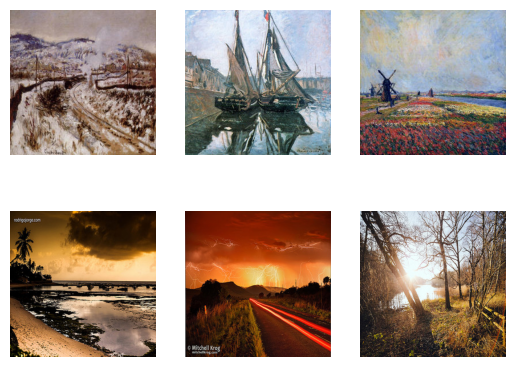

Loaded (300, 256, 256, 3) (300, 256, 256, 3)


1/1 [==============================] - 1s 840ms/step


Iteration>1, dX[1.238,1.273] dY[1.060,0.841] g[18.266,17.212]
1/1 [==============================] - 0s 29ms/step
Iteration>2, dX[1.922,0.978] dY[3.823,0.847] g[20.885,17.642]
1/1 [==============================] - 0s 28ms/step
Iteration>3, dX[3.440,2.234] dY[3.130,2.631] g[27.618,18.068]
1/1 [==============================] - 0s 28ms/step
Iteration>4, dX[6.623,1.826] dY[9.120,3.271] g[23.111,20.704]
1/1 [==============================] - 0s 39ms/step
Iteration>5, dX[2.079,2.847] dY[7.177,3.534] g[18.510,15.421]
1/1 [==============================] - 0s 28ms/step
Iteration>6, dX[2.469,6.197] dY[4.864,1.100] g[19.485,16.195]
1/1 [==============================] - 0s 47ms/step
Iteration>7, dX[1.122,7.792] dY[5.181,2.100] g[16.667,15.195]
1/1 [==============================] - 0s 34ms/step
Iteration>8, dX[2.248,2.853] dY[3.596,4.415] g[20.818,14.488]
1/1 [==============================] - 0s 28ms/step
Iteration>9, dX[0.983,2.103] dY[1.668,1.023] g[15.244,14.252]
1/1 [=====================

>Saved: g_model_XtoY_001500.h5 and g_model_YtoX_001500.h5
Execution time is:  1:01:18.710869


In [19]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.utils import img_to_array
from keras.utils import load_img
from matplotlib import pyplot as plt
import numpy as np

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)


# dataset path 
path = '/content/drive/MyDrive/monet2photo/'


# load dataset X - Monet paintings
dataX_all = load_images(path + 'trainA/')
print('Loaded dataX: ', dataX_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataX = resample(dataX_all, 
                 replace=False,     
                 n_samples=300,    
                 random_state=42) 

# load dataset Y - Photos 
dataY_all = load_images(path + 'trainB/')
print('Loaded dataY: ', dataY_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataY = resample(dataY_all, 
                 replace=False,     
                 n_samples=300,    
                 random_state=42) 

# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataX[i].astype('uint8'))
 
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataY[i].astype('uint8'))
plt.show()



# load image data
data = [dataX, dataY]

print('Loaded', data[0].shape, data[1].shape)

''' Change input range to values between -1 and 1 to Preprocess data 
  As the generator uses tanh activation in the output layer and tanh ranges between -1 and 1 '''
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: (G) X -> Y
g_model_XtoY = generator(image_shape)
# generator: (F) Y -> X
g_model_YtoX = generator(image_shape)
# discriminator: X -> [real/fake]
d_model_X = discriminator(image_shape)
# discriminator: Y -> [real/fake]
d_model_Y = discriminator(image_shape)
# composite: X -> Y -> [real/fake, X]
c_model_XtoY = composite_model(g_model_XtoY, d_model_Y, g_model_YtoX, image_shape)
# composite: Y -> X -> [real/fake, Y]
c_model_YtoX = composite_model(g_model_YtoX, d_model_X, g_model_XtoY, image_shape)

from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_X, d_model_Y, g_model_XtoY, g_model_YtoX, c_model_XtoY, c_model_YtoX, dataset, epochs=5)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

############################################


#### Image translation ####
 
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
 
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
X_data = resample(dataX_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

Y_data = resample(dataY_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

X_data = (X_data - 127.5) / 127.5
Y_data = (Y_data - 127.5) / 127.5



1/1 [==============================] - 1s 816ms/step


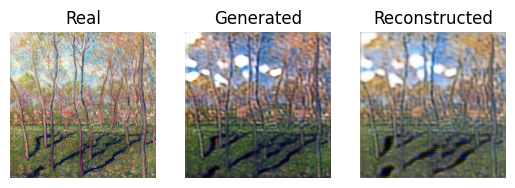

1/1 [==============================] - 0s 24ms/step


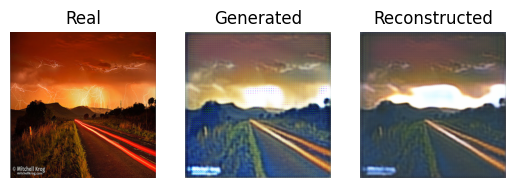

1/1 [==============================] - 2s 2s/step


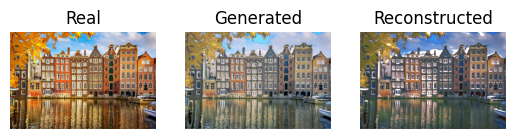

In [49]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_XtoY = load_model('/content/drive/MyDrive/Monet2photo_models/g_model_XtoY_001000.h5', cust)
model_YtoX = load_model('/content/drive/MyDrive/Monet2photo_models/g_model_YtoX_001000.h5', cust)

# plot X->Y->X (Monet to photo to Monet)
X_real = select_sample(X_data, 1)
Y_generated  = model_XtoY.predict(X_real)
X_reconstructed = model_YtoX.predict(Y_generated)
show_plot(X_real, Y_generated, X_reconstructed)

# plot Y->X->Y (Photo to Monet to Photo)
Y_real = select_sample(Y_data, 1)
X_generated  = model_YtoX.predict(Y_real)
Y_reconstructed = model_XtoY.predict(X_generated)
show_plot(Y_real, X_generated, Y_reconstructed)

##########################
#Load a single custom image
test_image = load_img('/content/drive/MyDrive/monet2photo/amsterdam.jpg')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

# plot Y->X->Y (Photo to Monet to Photo)
monet_generated  = model_YtoX.predict(test_image_input)
photo_reconstructed = model_XtoY.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)
